In [1]:
from __future__ import (absolute_import, division, print_function)
from six.moves import (filter, input, map, range, zip)  # noqa

import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt

import numpy
import cartopy.crs as ccrs

from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear

In [2]:
%matplotlib inline

In [3]:
fname = '/g/data/ua6/drstree/CMIP5/GCM/CSIRO-BOM/ACCESS1-0/historical/mon/ocean/thetao/r1i1p1/thetao_Omon_ACCESS1-0_historical_r1i1p1_185001-185412.nc'
cube = iris.load_cube(fname, 'sea_water_potential_temperature')

/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:794: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:794: UserWarning: Missing CF-netCDF measure variable u'volcello', referenced by netCDF variable u'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:1139: UserWarning: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warnings.warn(msg)


In [4]:
print(cube)

sea_water_potential_temperature          (time: 60; depth: 50; cell index along second dimension: 300; cell index along first dimension: 360)
     Dimension coordinates:
          time                                  x          -                                      -                                      -
          depth                                 -          x                                      -                                      -
          cell index along second dimension     -          -                                      x                                      -
          cell index along first dimension      -          -                                      -                                      x
     Auxiliary coordinates:
          latitude                            -          -                                      x                                      x
          longitude                           -          -                                      x            

In [5]:
print(cube[0, 0])

sea_water_potential_temperature / (K) (cell index along second dimension: 300; cell index along first dimension: 360)
     Dimension coordinates:
          cell index along second dimension                             x                                      -
          cell index along first dimension                              -                                      x
     Auxiliary coordinates:
          latitude                                                      x                                      x
          longitude                                                     x                                      x
     Scalar coordinates:
          depth: 5.0 m, bound=(0.0, 10.0) m
          time: 1850-01-16 12:00:00, bound=(1850-01-01 00:00:00, 1850-02-01 00:00:00)
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_ACCESS1-0_historical_r0i0p0.nc...
          branch_time: 

AttributeError: 'AxesSubplot' object has no attribute 'coastlines'

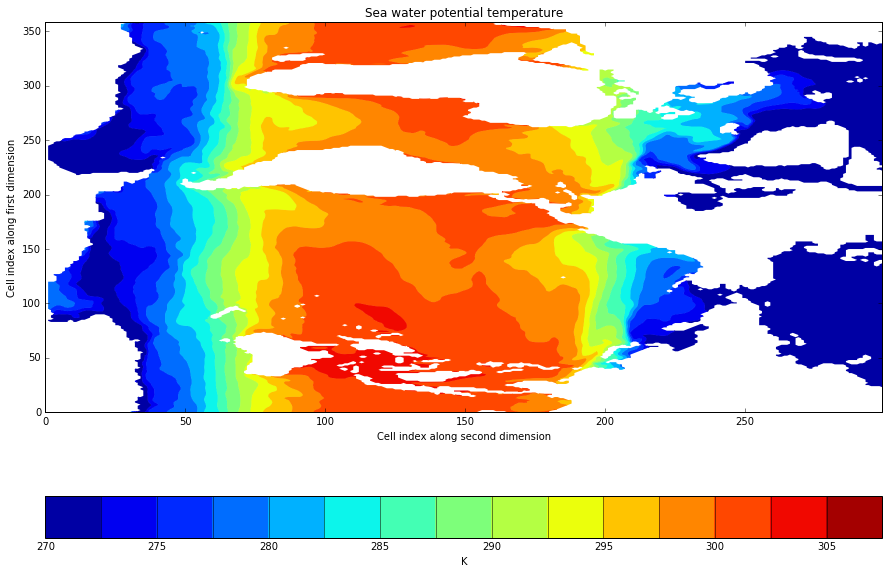

In [6]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(111)
qplt.contourf(cube[0,0], 15)
plt.gca().coastlines()

iplt.show()

## Try regular interpolation

In [7]:
lat1 = numpy.arange(-90, 91, 1)
lon1 = numpy.arange(0, 361, 1)

result = cube.interpolate([('latitude', lat1), ('longitude', lon1)], iris.analysis.Linear())

ValueError: Interpolation coords must be 1-d for rectilinear interpolation.

## Try regular regrid

In [9]:
def make_grid(lat_values, lon_values):
    """Make a dummy cube with desired grid."""
    
    #coordsys = iris.coord_systems.RotatedGeogCS(np_lat, np_lon)
    
    latitude = iris.coords.DimCoord(lat_values,
                                    standard_name='latitude',
                                    units='degrees_north',
                                    coord_system=None)
    longitude = iris.coords.DimCoord(lon_values,                     
                                     standard_name='longitude',
                                     units='degrees_east',
                                     coord_system=None)

    dummy_data = numpy.zeros((len(lat_values), len(lon_values)))
    new_cube = iris.cube.Cube(dummy_data, dim_coords_and_dims=[(latitude, 0), (longitude, 1)])
    
    return new_cube

In [10]:
target_grid_cube = make_grid(lat1, lon1)
scheme = iris.analysis.Linear(extrapolation_mode='mask')

In [11]:
cube_regridded = cube.regrid(target_grid_cube, scheme)

ValueError: Cube u'sea_water_potential_temperature' must contain a single 1D x coordinate.

## Try experimental regrid

See [this page](http://scitools.org.uk/iris/docs/v1.9.0/html/iris/iris/experimental/regrid.html?highlight=curvilinear#iris.experimental.regrid.regrid_weighted_curvilinear_to_rectilinear) for details.

In [12]:
src_cube = cube[0, 0]
weights = numpy.ones(src_cube.shape)

In [13]:
target_grid_cube.coord('longitude').guess_bounds()
target_grid_cube.coord('latitude').guess_bounds()

In [14]:
print(target_grid_cube.coord('longitude').bounds[0])
print(target_grid_cube.coord('longitude').bounds[-1])

[-0.5  0.5]
[ 359.5  360.5]


In [15]:
regridded_cube = regrid_weighted_curvilinear_to_rectilinear(src_cube, weights, target_grid_cube)

In [16]:
print(regridded_cube)

sea_water_potential_temperature / (K) (latitude: 181; longitude: 361)
     Dimension coordinates:
          latitude                             x               -
          longitude                            -               x
     Scalar coordinates:
          depth: 5.0 m, bound=(0.0, 10.0) m
          time: 1850-01-16 12:00:00, bound=(1850-01-01 00:00:00, 1850-02-01 00:00:00)
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_ACCESS1-0_historical_r0i0p0.nc...
          branch_time: 109207.0
          cmor_version: 2.8.0
          contact: The ACCESS wiki: http://wiki.csiro.au/confluence/display/ACCESS/Home. Contact...
          creation_date: 2012-01-15T15:19:48Z
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113,...
          frequency: mon
          history: 2012-

/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


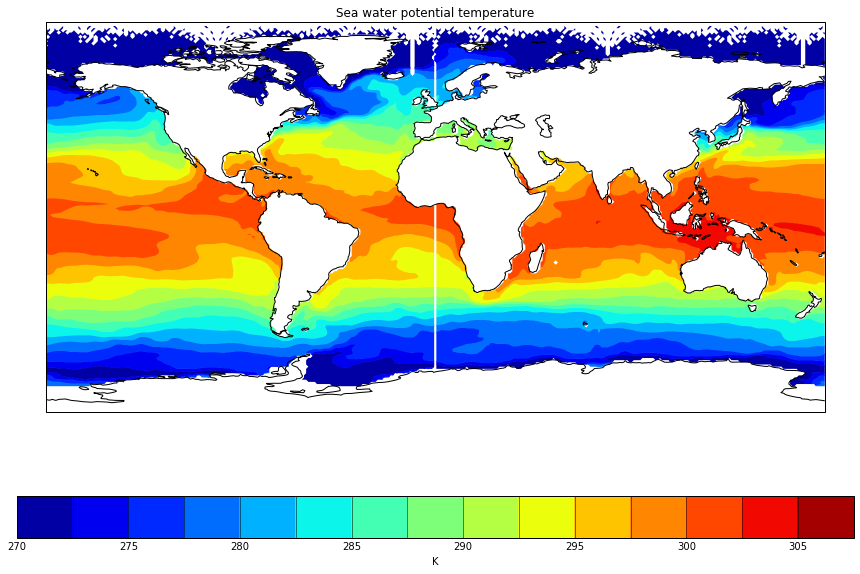

In [17]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(111)
qplt.contourf(regridded_cube, 15)
plt.gca().coastlines()

iplt.show()